<a href="https://colab.research.google.com/github/MarkStephens060482/Beijing-Air-Quality/blob/main/Assignment_2_SVR_model_book_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Foundations of Computer Science - Python B
### Mark Stephens - a1847018

# Beijing Multi-Site Air Quality dataset

<center>
<h2> The Data </h2>
    
The data used in this project was sourced from Machine Learning Repository, https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data. The dataset contains daily weather information of temperature, pressure, dewpoint, precipitation, wind direction and wind speed. The data set has undergone preprocessing of missing value imputation, removeal of outliers and some variable transformation.

***
## Loading the cleaned data set
The preprocessed dataset is loaded


In [ ]:
# importing important libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, glob

#_________The data files are to be loaded into current working directory___________
# Get the current working directory
cwd = os.getcwd()

file = cwd + '\clean_beijing_df.csv'

with open(file,encoding="utf-8") as dataFile:
        beijing_df = pd.read_csv(dataFile,index_col=0)
# view the dataframe
beijing_df.head()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,wd,station,weekend
0,2013,3,1,0,4.0,4.0,4.0,7.000000,300.0,77.0,-0.7,1023.0,-18.8,0.0,4.4,NNW,Aotizhongxin,no
1,2013,3,1,0,3.0,6.0,13.0,7.000000,300.0,85.0,-2.3,1020.8,-19.7,0.0,0.5,E,Changping,no
2,2013,3,1,0,4.0,4.0,3.0,3.997836,200.0,82.0,-2.3,1020.8,-19.7,0.0,0.5,E,Dingling,no
3,2013,3,1,0,9.0,9.0,3.0,17.000000,300.0,89.0,-0.5,1024.5,-21.4,0.0,5.7,NNW,Dongsi,no
4,2013,3,1,0,4.0,4.0,14.0,20.000000,300.0,69.0,-0.7,1023.0,-18.8,0.0,4.4,NNW,Guanyuan,no


### Support Vector Regression
The preprocessing steps to use for SVR are are follows:
1. drop unimportant features based on exploratory data analysis.
2. one hot encode selected categorical variables.
3. standardise selected feature variables.

The transformer defined previously for the Principal Component Regression model is used again for the preprocessing step in the pipeline. The Support Vector Machine Regressor is then defined and added in the pipeline.

In [ ]:
from sklearn.svm import LinearSVR
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline 

# list of unwanted features for linear regression model
drop_features = ['year','month','day','PM10', 'RAIN','station']

#list of selected categorical features
cat_features = ['weekend','wd']

#initialise One Hot encoder
OHenc = OneHotEncoder()

#define column transformer to drop particular columns and One Hot encode nominal variables.
transformer = make_column_transformer(
    ('drop',drop_features),
    (OHenc,cat_features),
    remainder="passthrough")

# initialise standard scaler
scaler = StandardScaler()

# define the preprocessing pipeline. Transformer is defined previously.
preprocessing_svr = make_pipeline(transformer,
                                      scaler)
# The Support Vector Machine Regressor is initialised
regressor_svr = LinearSVR()

# define the pipeline for Support Vector Machine Regression.
pipeline_svr = make_pipeline(preprocessing_svr, regressor_svr)

#### Dummy Regressor
Use a 'mean' strategy to establish a baseline for model performance.

In [ ]:
from sklearn.dummy import DummyRegressor
# initiialise the dummy regressor
regressor_dummy = DummyRegressor(strategy='mean')
#develop a pipeline model for the dummy regressor
pipeline_dummy = make_pipeline(regressor_dummy)

***
### Data Segregation
The cleaned dataset *beijing_df* is seperated into predictors and target variable and then split into a training and test datasets. 
A k-Fold Cross Validation splitting method is defined.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

sample_frac = 0.2
#Random sample of observation.
beijing_sample = beijing_df.sample(frac = sample_frac)

# seperate variables into features (X)  and target (y) .
X = beijing_sample.drop(columns = 'PM2.5')
y = beijing_sample['PM2.5']

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

new_line = '\n'
print(f'Training dataset:{new_line}\
X_train = { X_train.shape} {new_line}\
y_train = { y_train.shape}{new_line}')

print(f'Testing dataset:{new_line}\
X_test = {X_test.shape}{new_line}\
y_test = {y_test.shape}')

n_splits = 5

# Cross - validation strategy
splitter = KFold(n_splits = n_splits, shuffle = True, random_state=20)


Training dataset:
X_train = (65021, 17) 
y_train = (65021,)

Testing dataset:
X_test = (16256, 17)
y_test = (16256,)


***
### Model fitting and Hyper parameter tuning
Both the untuned and tuned models are to be evaluated using cross validation

#### Evaluating the untuned model using cross validation
The models are looped through and the mean value and standard error of the scoring metrics of RMSE and MSE are determined under cross-validation.

In [ ]:
from sklearn.model_selection import cross_validate

# define of estimators including the dummy regressor
pipelines = [pipeline_dummy, pipeline_svr]

scoring = ['neg_root_mean_squared_error', 'neg_mean_squared_error','r2']

model_scores1 = []
model_scores2 = []
model_scores3 = []
# loop over the model pipelines
for pipe in pipelines:
    
    # perform cross validation to get cv performance scores
    cv_results = cross_validate(pipe,X_train,
                                y_train,
                                scoring =scoring,
                                cv = splitter,
                                n_jobs=-1,                                   
                                verbose = 3)
    
    # determine mean and standard deviation of cv performance RMSE
    mean_RMSE = -1*cv_results['test_neg_root_mean_squared_error'].mean() 
    stdev_RMSE = cv_results['test_neg_root_mean_squared_error'].std()
    
     # determine mean and standard deviation of cv performance MSE
    mean_MSE = -1*cv_results['test_neg_mean_squared_error'].mean() 
    stdev_MSE = cv_results['test_neg_mean_squared_error'].std()
    
     # determine mean and standard deviation of cv performance r^2 score
    mean_r2 = cv_results['test_r2'].mean() 
    stdev_r2 = cv_results['test_r2'].std()
        
    # standard error of the Cross validation scores
    sterr_RMSE = stdev_RMSE/np.sqrt(n_splits)
    sterr_MSE = stdev_MSE/np.sqrt(n_splits)
    sterr_r2 = stdev_r2/np.sqrt(n_splits)
    
    # mean cross validationm scores with error
    score_RMSE = f'{mean_RMSE: .2f} \u00B1 {2*sterr_RMSE: .2f}'
    score_MSE = f'{mean_MSE: .2f} \u00B1 {2*sterr_MSE: .2f}'
    score_r2 = f'{mean_r2: .2f} \u00B1 {2*sterr_r2: .2f}'
        
    # append model name and cv score to list
    model_scores1.append(score_RMSE)
    model_scores2.append(score_MSE)
    model_scores3.append(score_r2)

# express as a Data Frame
results_df = pd.DataFrame(np.array([model_scores1,model_scores2,model_scores3]), 
                          columns = ["Dummy Regressor","Untuned SVR model"], 
                          index = ['RMSE','MSE','r2'])
results_df

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.3s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished


,Dummy Regressor,Untuned SVR model
RMSE,70.33 ± 0.71,39.33 ± 0.32
MSE,4947.21 ± 99.67,1546.96 ± 25.19
r2,-0.00 ± 0.00,0.69 ± 0.00


#### Hyper parameter tuning
The hyper parameters of each model are tuned using a hybrid approach of Randomised Search and Grid Search cross validation. The Randomised search identifies a ball park value for the optimum hyper parameter, while the grid seach will conduct a finer search within a range of some percentage either side of the value. 

#### Randomised Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform, randint
import numpy as np

#defining the hyperparameter space ranges
# Examining verbose suggests that C >20 fails to converge.
C_range = np.logspace(-2,1.25,1000)
#gamma_range = np.logspace(-2, 0.25, 1000)
epsilon_range = np.logspace(-1, 1.25, 1000)


#Principal Component Regression 
random_param_svr = {'linearsvr__C' : C_range,
                    'linearsvr__epsilon': epsilon_range,
                    'linearsvr__loss' : ['epsilon_insensitive']}
                                         #'squared_epsilon_insensitive']}
                  
# Conduct random search within the region of the optimal hyperparameters
random_search = RandomizedSearchCV(pipeline_svr,
                                   random_param_svr,
                                   n_iter = 100,
                                   cv = splitter,
                                   scoring = scoring,
                                   refit='neg_root_mean_squared_error',
                                   n_jobs = -1,
                                   verbose=3)
# fit the model
random_search.fit(X_train, y_train)

# Get the best hyperparameters from the random search
best_random = random_search.best_params_

# define best hyperparameters from Randomsearchcv
best_C = best_random['linearsvr__C']
#best_gamma = best_random['pipeline__svr__gamma']
best_epsilon = best_random['linearsvr__epsilon']
new_line = '\n'
print(f'Best hyper parameters for Randomised search are: {new_line}\
{best_random}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best hyper parameters for Randomised search are: 
{'linearsvr__loss': 'epsilon_insensitive', 'linearsvr__epsilon': 16.28214851273792, 'linearsvr__C': 8.344905470182525}


#### Grid search
The grid search range of hyper parameter values is define with a width proportion, *wp*, either side of the best value identified from the randomised search. The number of values in the grid search is defined as the given parameter *n*.

In [ ]:
# proportion of width
wp = 0.2
# number of values
n = 10

# Define the hyperparameter grid for the grid search
grid_param_svr = {'linearsvr__C' : best_C*(1 + np.arange(-wp, wp, 2*wp/(n-1))),
                  'linearsvr__epsilon' : best_epsilon*(1 + np.arange(-wp, wp, 2*wp/(n-1)))
                 }

# Conduct grid search to identify the general region of the optimal hyperparameters
grid_search = GridSearchCV(pipeline_svr, 
                           grid_param_svr,
                           cv = splitter,
                           n_jobs = -1,
                           verbose = 3,
                           scoring = scoring,
                           refit='neg_root_mean_squared_error')

# fitting the model
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the grid search
best_grid = grid_search.best_params_

# Train the final model with the best hyperparameters from the hybrid grid-random search
svr_final = pipeline_svr.set_params(**{'linearsvr__C' : best_grid['linearsvr__C'],
                                        'linearsvr__epsilon' : best_grid['linearsvr__epsilon']})
#Fit the final model
svr_final.fit(X_train, y_train)

# best mean cross-validation RMSE score
mean_RMSE = round(-1*grid_search.best_score_,2)
    
# best mean cross-validation MSE score
mean_MSE = round(-1*grid_search.cv_results_['mean_test_neg_mean_squared_error'][grid_search.best_index_],2)

# best mean cross-validation r2 score
mean_r2 = round(grid_search.cv_results_['mean_test_r2'][grid_search.best_index_],2)

# standard error of mean cross-validation RMSE score
sterr_RMSE = round((grid_search.cv_results_['std_test_neg_root_mean_squared_error'][grid_search.best_index_])/np.sqrt(n_splits),2)

 # standard error of mean cross-validation r2 score
sterr_r2 = round((grid_search.cv_results_['std_test_r2'][grid_search.best_index_])/np.sqrt(n_splits),2)

# standard error of mean cross-validation MSE score
sterr_MSE = round((grid_search.cv_results_['std_test_neg_mean_squared_error'][grid_search.best_index_])/np.sqrt(n_splits),2)
    
#summary of evaluation metrics
results_df = results_df.join(pd.DataFrame([(str(mean_RMSE)+" \u00B1 "+str(2*sterr_RMSE)),
                              (str(mean_MSE)+" \u00B1 "+str(2*sterr_MSE)),
                              (str(mean_r2)+" \u00B1 "+str(2*sterr_r2))],
                             columns = ["Tuned SVR model"],
                             index = ['RMSE','MSE','r2']))
results_df

Fitting 5 folds for each of 81 candidates, totalling 405 fits


,Dummy Regressor,Untuned SVR model,Tuned SVR model
RMSE,70.33 ± 0.71,39.33 ± 0.32,38.55 ± 0.3
MSE,4947.21 ± 99.67,1546.96 ± 25.19,1486.26 ± 23.02
r2,-0.00 ± 0.00,0.69 ± 0.00,0.7 ± 0.0


In [ ]:
new_line = '\n'
print(f'Best hyper parameters after Randomised and Grid search are: {new_line}\
{best_grid}')

Best hyper parameters after Randomised and Grid search are: 
{'linearsvr__C': 8.530347813964358, 'linearsvr__epsilon': 18.81492717027493}


### Model Evaluation
The final model is evaluated using the test data set. The performance metrics are observed and compared.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
# predict on the test data set
y_svr_pred = svr_final.predict(X_test)

# Calculate Mean Squared error
MSE_test = round(mean_squared_error(y_test, y_svr_pred),2)
# Calculate Root Mean Squared Error
RMSE_test = round(np.sqrt(mean_squared_error(y_test, y_svr_pred)),2)
# Calculate r2 score
r2_test = round(r2_score(y_test, y_svr_pred),2)


results_df.join(pd.DataFrame([RMSE_test,MSE_test,r2_test],
                             columns = [" SVR model performance on test data"], 
                             index = ["RMSE","MSE",'r2'])) 

,Dummy Regressor,Untuned SVR model,Tuned SVR model,SVR model performance on test data
RMSE,70.33 ± 0.71,39.33 ± 0.32,38.55 ± 0.3,38.59
MSE,4947.21 ± 99.67,1546.96 ± 25.19,1486.26 ± 23.02,1489.24
r2,-0.00 ± 0.00,0.69 ± 0.00,0.7 ± 0.0,0.70


### Plot of Predicted against True values and Learning Curve Plot
This is a visualisation of cross-validation training and test scores for different set sizes, applied to the whole data set. The visualisation shows the effect of adding more samples during the training process.

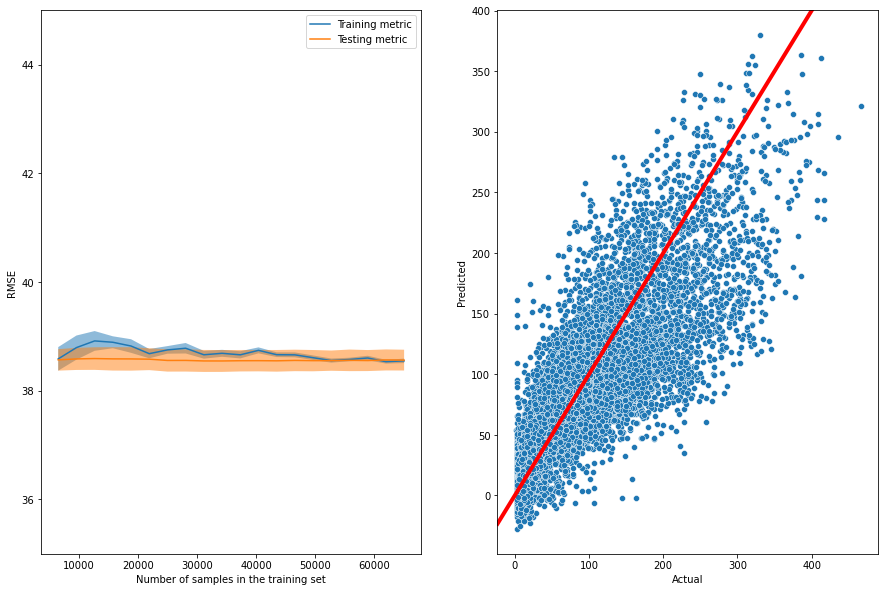

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import LearningCurveDisplay

fig,axs = plt.subplots(1,2, figsize = (15,10))

# Produce a Learning Curve Identifying training and test scores
train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
    svr_final,
    X, 
    y,
    train_sizes = np.linspace(0.1,1,20),
    return_times= True,
    #scoring = 'neg_root_mean_squared_error',
    n_jobs=-1,
    random_state = 20,
    scoring = "neg_root_mean_squared_error",
    cv = splitter)

display = LearningCurveDisplay(train_sizes=train_sizes,
                               train_scores=train_scores, 
                               test_scores=test_scores, 
                               score_name="RMSE")

display.plot(ax = axs[0],
             score_type='both',
             std_display_style='fill_between',
             negate_score = True)

axs[0].set_ylim(35,45)

pred_data = pd.DataFrame(np.c_[y_test, y_svr_pred], columns = ['Actual','Predicted'])
sns.scatterplot(data =pred_data,
                x = 'Actual',
                y = 'Predicted',
               ax = axs[1])

axs[1].axline((0, 0), slope=1,linewidth=4, color='r')


#### Figure 10: The learning curve and predicted vs actual plots for Linear SVR model
The learning curve suggests that the Linear Support Vector Regressor has plateaued in performance as the test score has not changed with increased size in training data. Therefore the model will not benefit from increasing the sample size. The scatter plot of predicted vs actual values show that there is significant variance in prediction as the linear SV regressor had not captured the non-linear complexity. A number of significant residuals are observed.

### Scalability of the model
The SVR model is fitted to a sample of the dataset a fraction of the size. If the model was to scale up to a larger amount of data, then the graphs below suggest the expected trend in computational times as more samples of data are added for model training. Also the trade off between increased fitting times and the cross validation score shows if up scaling a SVR model is worth doing.

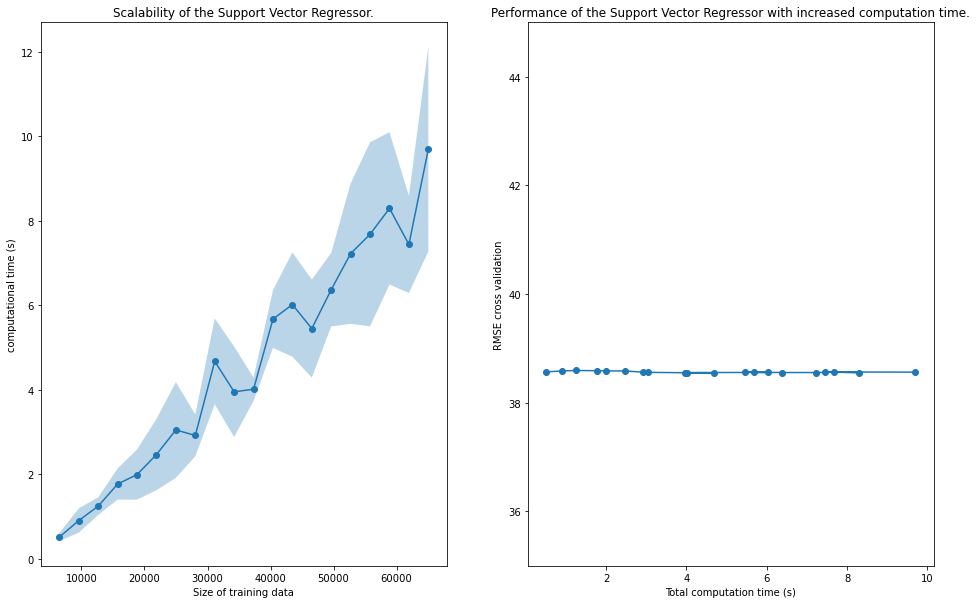

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))

total_times = fit_times + score_times
# plots training size vs total computation time
axs[0].plot(train_sizes, total_times.mean(axis=1), "o-")
axs[0].fill_between(
        train_sizes,
        total_times.mean(axis=1) - total_times.std(axis=1),
        total_times.mean(axis=1) + total_times.std(axis=1),
        alpha=0.3)
axs[0].set_ylabel("computational time (s)")
axs[0].set_xlabel("Size of training data")
axs[0].set_title("Scalability of the Support Vector Regressor.")

# plots cross validation score with total computation time
axs[1].plot(total_times.mean(axis=1), -1*test_scores.mean(axis=1), "o-")
axs[1].fill_between(
        total_times.mean(axis=1),
        test_scores.mean(axis=1) - test_scores.std(axis=1),
        test_scores.mean(axis=1) + test_scores.std(axis=1),
        alpha=0.3)
axs[1].set_ylabel("RMSE cross validation")
axs[1].set_ylim(35,45)
axs[1].set_xlabel("Total computation time (s)")
axs[1].set_title("Performance of the Support Vector Regressor with increased computation time.")

plt.show()

#### Figure 11: Scalability of the Linear Support Vector Regression model
The graphs show that as the size of the training data increases, the computation time rapidly increases as well, with not gain in model performance. Hence there is no benefit in up scaling the model to the larger data set.